<a href="https://colab.research.google.com/github/skj092/mask-detector/blob/main/Mask_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

**We need utils, transform, coco_eval, engine, coco_utils modues from the torchvision**

In [1]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 184587, done.
remote: Counting objects: 100% (4686/4686), done.
remote: Compressing objects: 100% (502/502), done.
remote: Total 184587 (delta 4250), reused 4571 (delta 4172), pack-reused 179901
Receiving objects: 100% (184587/184587), 364.28 MiB | 36.24 MiB/s, done.
Resolving deltas: 100% (165549/165549), done.
fatal: not a git repository (or any of the parent directories): .git


**For data autmentation we require albumentations, sice chrome doesn't have latest version, so we will upgrade to the latest version**

In [2]:
!pip install --upgrade albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip uninstall opencv-python-headless -y

Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Successfully uninstalled opencv-python-headless-4.6.0.66


In [ ]:
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.6 MB/s 


In [3]:
# Importing necessary libraries 

import os 
from pathlib import Path 
import xml.etree.ElementTree as ET 
from torch.utils.data import Dataset
from PIL import Image
import torch 
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import cv2 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# Downloading the dataset

Environment setup is complete, Now I am gonna download the dataset from roboflow Roboflow hosts free public computer vision datasets in many popular formats (including CreateML JSON, COCO JSON, Pascal VOC XML, YOLO v3, and Tensorflow TFRecords).

In [ ]:
 %%bash

wget "https://public.roboflow.com/ds/kQQWZNGxGA?key=65kkvLv3xW" -O data.zip 

unzip -q data.zip

rm data.zip 

ls

**Note:**: One Image "0_8w7mkX-PHcfMM5s6_jpeg.rf.039eb72a4757882968537a6ae94d198f.jpg" in the dataset is incorrectly labeled, so I'll delete this image from the directory. 

In [5]:
!rm train/0_8w7mkX-PHcfMM5s6_jpeg.rf.039eb72a4757882968537a6ae94d198f.jpg 

# Define Transform 

Initially I'll use simple transform function to test the model. 

In [6]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Object detection model want a dataset which has 2 fields:


1.   image 
2.   target ( a dict containing the following fields:)


> boxes (FloatTensor[N, 4}) 
> Labels (Int64Tensor[N])
> image_id (Int64Tensor[1])
> iscrowd(UInt8Tensor[N])

So we will make a dataset class which produces the the output in above file format.






In [7]:
class MaskDetectionDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = Path(root)
        self.transforms = transforms
        self.image_paths = list(self.root.glob('*.jpg'))
        self.image_paths.sort()
        self.mask_paths = [p.parent / (p.stem + '.xml') for p in self.image_paths]

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Parsing xml to get the labels and the bounding boxes
        annotation = ET.parse(mask_path)
        root = annotation.getroot()
        objects = root.findall('object')
        boxes = []
        labels = []
        for obj in objects:
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(name)

        # Converting the labels and the bounding boxes to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = list(map(lambda x: 1 if x == 'mask' else 0, labels))
        labels = torch.as_tensor(labels)
        image_id = torch.tensor([idx])

        # Other parameters
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        # Creating the tensor for the dataset
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        # Applying the transforms
        if self.transforms is not None:
          image = self.transforms(image)

        return image, target


    def __len__(self):
        return len(self.image_paths)

# Visualization 

In [8]:
train_dataset = MaskDetectionDataset('train')

# label2 class
def class2lbl(label):
    if label == 1:
        return 'mask'
    else:
        return 'no_mask'


In [9]:
def show_img_bbox(img, target):
    fig = plt.figure(figsize=(10,10))
    bbox = target['boxes']
    label = target['labels']
    label = list(map(class2lbl, label.tolist()))
    for i in range(len(bbox)):
        xmin = int(bbox[i][0])
        ymin = int(bbox[i][1])
        xmax = int(bbox[i][2])
        ymax = int(bbox[i][3])
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(img, str(label[i]), (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    plt.imshow(img)
    plt.show()

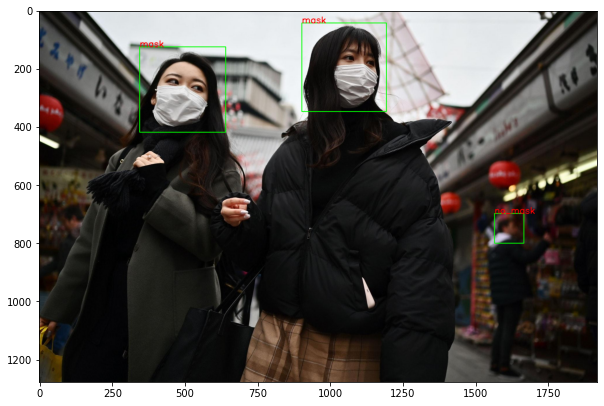

In [10]:
img, target = train_dataset[1]
show_img_bbox(img, target)

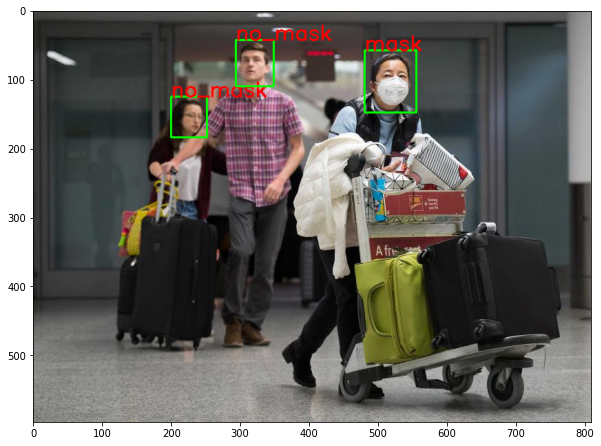

In [11]:
img, target = train_dataset[10]
show_img_bbox(img, target)

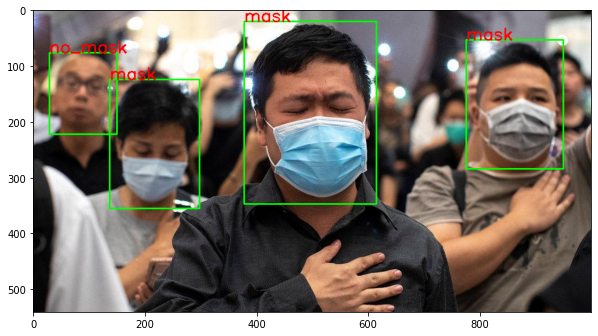

In [12]:
img, target = train_dataset[20]
show_img_bbox(img, target)

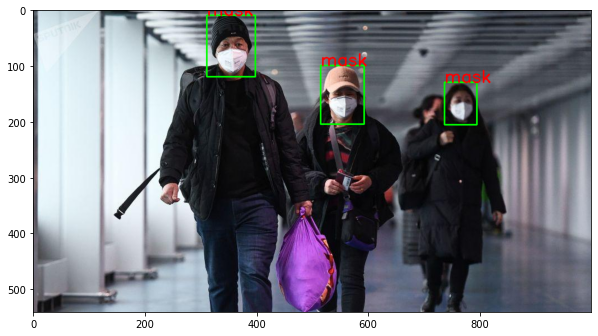

In [13]:
img, target = train_dataset[22]
show_img_bbox(img, target)

# Building Model

We will use Faster R-CNN model with a ResNet-50-FPN backbone from the Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks paper.

The input to the model is expected to be a list of tensors, each of shape [C, H, W], one for each image, and should be in 0-1 range. Different images can have different sizes.

The behavior of the model changes depending if it is in training or evaluation mode.

During training, the model expects both the input tensors, as well as a targets (list of dictionary), containing:

boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.

labels (Int64Tensor[N]): the class label for each ground-truth box

The model returns a Dict[Tensor] during training, containing the classification and regression losses for both the RPN and the R-CNN.

During inference, the model requires only the input tensors, and returns the post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as follows, where N is the number of detections:

boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.

labels (Int64Tensor[N]): the predicted labels for each detection

scores (Tensor[N]): the scores of each detection

In [14]:
# defining the model

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

# Training

In [15]:
train_ds = MaskDetectionDataset(root='train/', transforms=get_transform(train=True))
valid_ds = MaskDetectionDataset(root='valid/', transforms=get_transform(train=False))

train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)


# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=3,
                                            gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [16]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_dl, device=device)

Epoch: [0]  [ 0/52]  eta: 0:06:11  lr: 0.000103  loss: 1.4784 (1.4784)  loss_classifier: 1.1305 (1.1305)  loss_box_reg: 0.1377 (0.1377)  loss_objectness: 0.1900 (0.1900)  loss_rpn_box_reg: 0.0202 (0.0202)  time: 7.1488  data: 0.0343  max mem: 2565
Epoch: [0]  [10/52]  eta: 0:00:56  lr: 0.001082  loss: 1.0158 (0.9064)  loss_classifier: 0.5808 (0.5907)  loss_box_reg: 0.1377 (0.1720)  loss_objectness: 0.0957 (0.1259)  loss_rpn_box_reg: 0.0087 (0.0179)  time: 1.3436  data: 0.1115  max mem: 4416
Epoch: [0]  [20/52]  eta: 0:00:31  lr: 0.002062  loss: 0.9794 (0.8920)  loss_classifier: 0.3057 (0.5063)  loss_box_reg: 0.1958 (0.2332)  loss_objectness: 0.0957 (0.1333)  loss_rpn_box_reg: 0.0100 (0.0191)  time: 0.6868  data: 0.0738  max mem: 4416
Epoch: [0]  [30/52]  eta: 0:00:19  lr: 0.003041  loss: 0.9794 (0.9019)  loss_classifier: 0.3140 (0.4384)  loss_box_reg: 0.3457 (0.2987)  loss_objectness: 0.1000 (0.1431)  loss_rpn_box_reg: 0.0170 (0.0216)  time: 0.6174  data: 0.0403  max mem: 4416
Epoch: [

# Inferences

In [ ]:
# Save
torch.save(model, 'model.pt')

# Load
model_inf = torch.load('model.pt')
model_inf.eval()

In [117]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.05):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return T.ToPILImage()(img).convert('RGB')

# Inferences

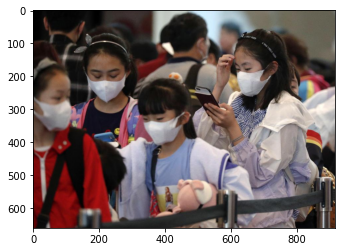

In [149]:
img = cv2.imread("/content/valid/0009S6815V3PEU1N-C123-F4_jpg.rf.128ad940f96aa8fa5174093ddb7ae5ee.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [150]:
image = get_transform(train=False)(img)

In [151]:
model = torch.load('model.pt', map_location='cpu')
model.eval()
image = image.unsqueeze(0)

In [152]:
prediction = model(image)[0]

In [153]:
len(prediction['boxes'])

77

In [154]:
final_prediction = apply_nms(prediction)
len(final_prediction['boxes'])

8

In [155]:
def draw_boxes(img, prediction):
    for i in range(len(prediction['boxes'])):
        box = prediction['boxes'][i].detach().numpy()
        cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
        cv2.putText(img, class2lbl(prediction['labels'][i].item()), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    return img

In [156]:
final_img = draw_boxes(img, final_prediction)

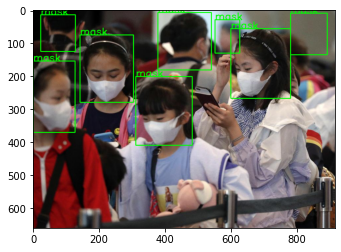

In [157]:
plt.imshow(final_img)